In [5]:
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.dates as mdates
%matplotlib inline
import tensorflow as tf
#from pathlib import Path
import os
from shutil import move, copy
from mpl_finance import candlestick2_ochl, volume_overlay

In [2]:
# Function to create a special symbol data in csv format

def createDataset(path, symbol, en_symbol, head):
    df = pd.read_csv(path)
    df = df[df.Symbol == symbol]
    df.index = pd.to_datetime(df['Date'])
    df = df.drop(columns=['Date']).dropna()
    df = df.head(head)
    
    if not os.path.exists("stock_datasets"):
        os.makedirs("stock_datasets")
    if not os.path.exists("stock_datasets/{}".format(en_symbol)):
        os.makedirs("stock_datasets/{}".format(en_symbol))
        
    path = "stock_datasets/{}/{}.csv".format(en_symbol, en_symbol)

    df.to_csv(path)
    
    print("{} dataset created.".format(en_symbol))
    print("Dataset path is: {}/{}".format(os.getcwd(), path))

In [3]:
# Function for labeling

def createLabel(path, days):
    print("Creating label . . .")
    
    # remove existing label file
    filename = path.split('/')
    label_path = "{}/{}/{}_label_{}days.txt".format(filename[0], filename[1], filename[2][:-4], days)

    df = pd.read_csv(path, parse_dates=True, index_col=0)
    df.fillna(0)

    df.reset_index(inplace=True)
    df['Date'] = df['Date'].map(mdates.date2num)
    for i in range(0, len(df)):
        c = df.loc[i:i + int(days), :]

        starting = 0
        endvalue = 0
        label = ""
        
        if len(c) == int(days)+1:
            starting = c["Last"].iloc[-2] 
            endvalue = c["Last"].iloc[-1]
            if endvalue > starting:
                label = 1
            else:
                label = 0
            with open(label_path, 'a') as the_file:
                the_file.write("{}-{},{}".format(filename[2][:-4], i, label))
                the_file.write("\n")
    print("Create label finished.")
    print("Label path is: {}/{}".format(os.getcwd(), label_path))

In [4]:
# Function for making candlestick chart images

def createCandles(path, days, pic_size, use_volume):
    print("Converting numerical data to candlestick chart...")
    symbol = path.split('/')[-1]
    symbol = symbol.split('.')[0]
    print("Symbol: {}".format(symbol))
    main_path = "{}".format(os.getcwd())
    #print(main_path)
    if use_volume:
        if not os.path.exists("{}/stock_datasets/{}/images/{}days_{}x{}pixel+volume".format(main_path, symbol, days, pic_size, pic_size)):
            os.makedirs("{}/stock_datasets/{}/images/{}days_{}x{}pixel+volume".format(main_path, symbol, days, pic_size, pic_size))
    else:
        if not os.path.exists("{}/stock_datasets/{}/images/{}days_{}x{}pixel".format(main_path, symbol, days, pic_size, pic_size)):
            os.makedirs("{}/stock_datasets/{}/images/{}days_{}x{}pixel".format(main_path, symbol, days, pic_size, pic_size))

    df = pd.read_csv(path, parse_dates=True, index_col=0)
    df.fillna(0)
    plt.style.use('dark_background')
    df.reset_index(inplace=True)
    df['Date'] = df['Date'].map(mdates.date2num)
    for i in range(0, len(df)):
        # Candle Stick Chart
        c = df.loc[i:i + int(days) - 1, :]
        if (len(c) == int(days)) and (i != (len(df) - days)):
        #if len(c) == int(days):
            my_dpi = 96
            fig = plt.figure(figsize=(pic_size/my_dpi, pic_size/my_dpi), dpi=my_dpi)
            ax1 = fig.add_subplot(1, 1, 1)
            candlestick2_ochl(ax1, c['Open'], c['Last'], c['High'], c['Low'], 
                              width=1, colorup='#77d879', colordown='#db3f3f')
            ax1.grid(False)
            ax1.set_xticklabels([])
            ax1.set_yticklabels([])
            ax1.xaxis.set_visible(False)
            ax1.yaxis.set_visible(False)
            ax1.axis('off')

            # create the second axis for the volume bar-plot
            # Add a second axis for the volume overlay
            if use_volume:
                ax2 = ax1.twinx()
                # Plot the volume overlay
                bc = volume_overlay(ax2, c['Open'], c['Last'], c['Volume'],
                                    colorup='#77d879', colordown='#db3f3f', alpha=0.5, width=1)
                ax2.add_collection(bc)
                ax2.grid(False)
                ax2.set_xticklabels([])
                ax2.set_yticklabels([])
                ax2.xaxis.set_visible(False)
                ax2.yaxis.set_visible(False)
                ax2.axis('off')
            if use_volume:
                pngfile = 'stock_datasets/{}/images/{}days_{}x{}pixel+volume/{}-{}.png'.format(symbol, days, pic_size, pic_size, symbol, i)
            else:
                pngfile = 'stock_datasets/{}/images/{}days_{}x{}pixel/{}-{}.png'.format(symbol, days, pic_size, pic_size, symbol, i)
            fig.savefig(pngfile, pad_inches=0, transparent=False)
            plt.close(fig)

    print("Converting numerical data to candlestick chart finished.")
    print('Address is:')
    if use_volume:
        print("{}/stock_datasets/{}/images/{}days_{}x{}pixel+volume".format(main_path, symbol, days, pic_size, pic_size))
    else:
        print("{}/stock_datasets/{}/images/{}days_{}x{}pixel".format(main_path, symbol, days, pic_size, pic_size))

In [6]:
# Function for separating images with different labels and separating train and validation data

def image2dataset(image_path, label_path, train_size):
    label_dict = {}
    with open(label_path) as f:
        for line in f:
            (key, val) = line.split(',')
            label_dict[key] = val.rstrip()
    path = "{}/{}".format(os.getcwd(), image_path)

    folders = ['train', 'validation']
    for folder in folders:
        if not os.path.exists("{}/{}".format(path, folder)):
            os.makedirs("{}/{}".format(path, folder))
    
    i = 0
    for filename in os.listdir(path):
        if label_path.split('/')[1] in filename:
            i += 1
            for k, v in label_dict.items():
                splitname = os.path.splitext(filename)[0].split("-")
                f, e = os.path.splitext(filename)
                newname = "{}-{}".format(splitname[0], splitname[1])
                if newname == k:
                    new_name = "{}{}.png".format(v, f)
                    #os.rename("{}/{}".format(path, filename), "{}/{}".format(path, new_name))
                    if i <= train_size:
                        move("{}/{}".format(path, filename),
                             "{}/train/{}".format(path, new_name))
                    else:
                        move("{}/{}".format(path, filename),
                             "{}/validation/{}".format(path, new_name))
                    break

    folders = ['1', '0']
    for folder in folders:
        if not os.path.exists("{}/train/{}".format(path, folder)):
            os.makedirs("{}/train/{}".format(path, folder))
        if not os.path.exists("{}/validation/{}".format(path, folder)):
            os.makedirs("{}/validation/{}".format(path, folder))

    paths = ["{}/train".format(path), "{}/validation".format(path)]
    for path in paths:
        for filename in os.listdir(path):
            if label_path.split('/')[1] in filename:
                # print(filename[:1])
                if filename[:1] == "1":
                    move("{}/{}".format(path, filename),
                         "{}/1/{}".format(path, filename))
                elif filename[:1] == "0":
                    move("{}/{}".format(path, filename),
                         "{}/0/{}".format(path, filename))
    print('Images converted to classified dataset.')

In [7]:
# Function for combining images of all symbols and preparing a large database

def mergeDatasets(days, pic_size, use_volume):
    symbols = []
    path = 'stock_datasets'
    for i in os.listdir(path):
        if i[0] != '.':
            symbols.append(i)
    main_path = "{}".format(os.getcwd())
    if use_volume:
        if not os.path.exists("{}/stock_datasets/all_symbols/{}days_{}x{}pixel+volume".format(main_path, days, pic_size, pic_size)):
            os.makedirs("{}/stock_datasets/all_symbols/{}days_{}x{}pixel+volume/train/0".format(main_path, days, pic_size, pic_size))
            os.makedirs("{}/stock_datasets/all_symbols/{}days_{}x{}pixel+volume/train/1".format(main_path, days, pic_size, pic_size))
            os.makedirs("{}/stock_datasets/all_symbols/{}days_{}x{}pixel+volume/validation/0".format(main_path, days, pic_size, pic_size))
            os.makedirs("{}/stock_datasets/all_symbols/{}days_{}x{}pixel+volume/validation/1".format(main_path, days, pic_size, pic_size))
    else:
        if not os.path.exists("{}/stock_datasets/all_symbols/{}days_{}x{}".format(main_path, days, pic_size, pic_size)):
            os.makedirs("{}/stock_datasets/all_symbols/{}days_{}x{}pixel/train/0".format(main_path, days, pic_size, pic_size))
            os.makedirs("{}/stock_datasets/all_symbols/{}days_{}x{}pixel/train/1".format(main_path, days, pic_size, pic_size))
            os.makedirs("{}/stock_datasets/all_symbols/{}days_{}x{}pixel/validation/0".format(main_path, days, pic_size, pic_size))
            os.makedirs("{}/stock_datasets/all_symbols/{}days_{}x{}pixel/validation/1".format(main_path, days, pic_size, pic_size))
            
    data_type = ['train', 'validation']
    label = ['0', '1']
    for symbol in symbols:
        if not os.path.exists('{}/stock_datasets/{}/images/{}days_{}x{}pixel+volume'.format(main_path, symbol, days, pic_size, pic_size)):
            continue
        for d in data_type:
            for l in label:
                if use_volume:
                    source_dir = '{}/stock_datasets/{}/images/{}days_{}x{}pixel+volume/{}/{}'.format(main_path, symbol, days, pic_size, pic_size, d, l)
                    target_dir = '{}/stock_datasets/all_symbols/{}days_{}x{}pixel+volume/{}/{}'.format(main_path, days, pic_size, pic_size, d, l)
                else:
                    source_dir = '{}/stock_datasets/{}/images/{}days_{}x{}pixel/{}/{}'.format(main_path, symbol, days, pic_size, pic_size, d, l)
                    target_dir = '{}/stock_datasets/all_symbols/{}days_{}x{}pixel/{}/{}'.format(main_path, days, pic_size, pic_size, d, l)
                
                file_names = os.listdir(source_dir)
                for file_name in file_names:
                    if file_name[0] != '.':
                        copy("{}/{}".format(source_dir, file_name),
                             "{}/{}".format(target_dir, file_name))
    print("New dataset with all of data created.")

In [8]:
# A function to get the number of images obtained from the previous function

def countImages(days, pic_size, use_volume):
    symbols = []
    path = 'stock_datasets'
    main_path = "{}".format(os.getcwd())
    if use_volume:
        train_0 = len(os.listdir("{}/stock_datasets/all_symbols/{}days_{}x{}pixel+volume/train/0".format(main_path, days, pic_size, pic_size)))
        train_1 = len(os.listdir("{}/stock_datasets/all_symbols/{}days_{}x{}pixel+volume/train/1".format(main_path, days, pic_size, pic_size)))
        valid_0 = len(os.listdir("{}/stock_datasets/all_symbols/{}days_{}x{}pixel+volume/validation/0".format(main_path, days, pic_size, pic_size)))
        valid_1 = len(os.listdir("{}/stock_datasets/all_symbols/{}days_{}x{}pixel+volume/validation/1".format(main_path, days, pic_size, pic_size)))
    else:
        train_0 = len(os.listdir("{}/stock_datasets/all_symbols/{}days_{}x{}pixel/train/0".format(main_path, days, pic_size, pic_size)))
        train_1 = len(os.listdir("{}/stock_datasets/all_symbols/{}days_{}x{}pixel/train/1".format(main_path, days, pic_size, pic_size)))
        valid_0 = len(os.listdir("{}/stock_datasets/all_symbols/{}days_{}x{}pixel/validation/0".format(main_path, days, pic_size, pic_size)))
        valid_1 = len(os.listdir("{}/stock_datasets/all_symbols/{}days_{}x{}pixel/validation/1".format(main_path, days, pic_size, pic_size)))
    all_images = train_0 + train_1 + valid_0 + valid_1
    all_trains = train_0 + train_1
    all_valids = valid_0 + valid_1
    train_percentage = all_trains / all_images
    validation_percentage = all_valids / all_images
    print('All: {} images'.format(all_images))
    print('{} images for training, include {} images belongs to label 0 and {} belongs to 1.'.format(all_trains, train_0, train_1))
    print('{} images for validation, include {} images belongs to label 0 and {} belongs to 1.'.format(all_valids, valid_0, valid_1))
    print('{:2.2%} for training'.format(train_percentage))
    print('{:2.2%} for validation'.format(validation_percentage))

In [9]:
# Show created pictures
def showImages(path):
    train_0_dir = os.path.join(path, 'train', '0')
    train_1_dir = os.path.join(path, 'train', '1')
    validation_0_dir = os.path.join(path, 'validation', '0')
    validation_1_dir = os.path.join(path, 'validation', '1')

    train_0_names = os.listdir(train_0_dir)
    train_1_names = os.listdir(train_1_dir)
    validation_0_names = os.listdir(validation_0_dir)
    validation_1_names = os.listdir(validation_1_dir)

    nrows = 4
    ncols = 4
    pic_index = 0
    fig = plt.gcf()
    fig.set_size_inches(ncols * 4, nrows * 4)
    pic_index += 8
    next_0_pix = [os.path.join(train_0_dir, fname)
                     for fname in train_0_names[pic_index-8:pic_index]]
    next_1_pix = [os.path.join(train_1_dir, fname)
                     for fname in train_1_names[pic_index-8:pic_index]]
    for i, img_path in enumerate(next_0_pix + next_1_pix):
        sp = plt.subplot(nrows, ncols, i + 1)
        sp.axis('off')
        img = mpimg.imread(img_path)
        plt.imshow(img)
    plt.show()

In [10]:
createLabel('stock_datasets/وغدير/وغدير.csv', 20)

Creating label . . .
Create label finished.
Label path is: /Users/omid/Downloads/files/master/4. Kusama2019/stock_datasets/وغدير/وغدير_label_20days.txt


In [11]:
createCandles('stock_datasets/وغدير/وغدير.csv', 20, 50, True)

Converting numerical data to candlestick chart...
Symbol: وغدير
Converting numerical data to candlestick chart finished.
Address is:
/Users/omid/Downloads/files/master/4. Kusama2019/stock_datasets/وغدير/images/20days_50x50pixel+volume


In [19]:
len(pd.read_csv('stock_datasets/وغدير/وغدير.csv')) * 0.8

2000.0

In [20]:
image2dataset('stock_datasets/وغدير/images/20days_50x50pixel+volume', 'stock_datasets/وغدير/وغدير_label_20days.txt', 2000)

Images converted to classified dataset.


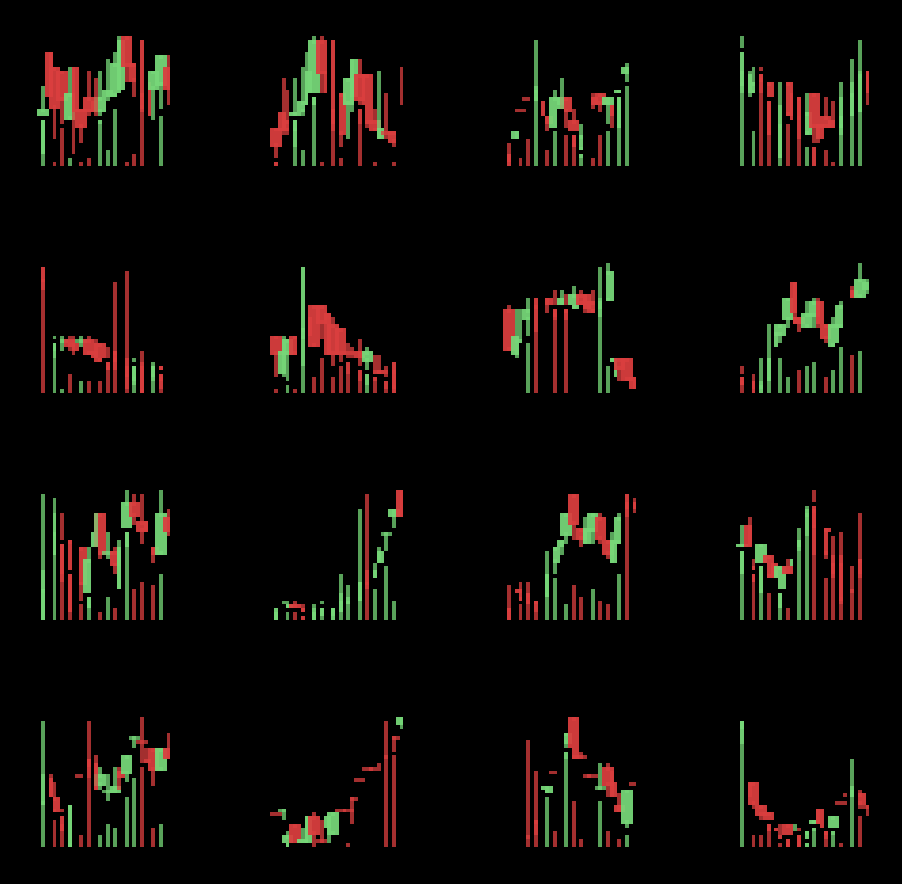

In [21]:
showImages('stock_datasets/وغدير/images/20days_50x50pixel+volume')

In [22]:
path = 'stock_datasets/وغدير/images/20days_50x50pixel+volume'

In [23]:
# Create the model
size = int(path.split('/')[-1].split('_')[-1].split('x')[0])

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(16, (3, 3), activation='relu', input_shape=(size, size, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Show summary of the model
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 48, 48, 16)        448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 24, 24, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 22, 22, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 11, 11, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 9, 9, 64)          18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 4, 4, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 1024)              0

In [24]:
# Compile the model
from tensorflow.keras.optimizers import RMSprop

model.compile(loss='binary_crossentropy',
              optimizer=RMSprop(learning_rate=0.001),
              metrics=['accuracy'])

In [25]:
# Prepare image to fit the model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1/255)
validation_datagen = ImageDataGenerator(rescale=1/255)

train_generator = train_datagen.flow_from_directory(os.path.join(path, 'train'),
                                                    target_size=(size, size),
                                                    batch_size=20,
                                                    class_mode='binary')
validation_generator = validation_datagen.flow_from_directory(os.path.join(path, 'validation'),
                                                    target_size=(size, size),
                                                    batch_size=20,
                                                    class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 480 images belonging to 2 classes.


In [26]:
history = model.fit(train_generator,
                    steps_per_epoch=100,
                    epochs=15,
                    validation_data=validation_generator,
                    verbose=1)

Epoch 1/15
100/100 [==============================] - 3s 25ms/step - loss: 0.6997 - accuracy: 0.4985 - val_loss: 0.6945 - val_accuracy: 0.4313
Epoch 2/15
100/100 [==============================] - 2s 19ms/step - loss: 0.6938 - accuracy: 0.5150 - val_loss: 0.6923 - val_accuracy: 0.5333
Epoch 3/15
100/100 [==============================] - 2s 19ms/step - loss: 0.6852 - accuracy: 0.5565 - val_loss: 0.6953 - val_accuracy: 0.5312
Epoch 4/15
100/100 [==============================] - 2s 20ms/step - loss: 0.6600 - accuracy: 0.6140 - val_loss: 0.7348 - val_accuracy: 0.5021
Epoch 5/15
100/100 [==============================] - 2s 19ms/step - loss: 0.6093 - accuracy: 0.6700 - val_loss: 0.7381 - val_accuracy: 0.5333
Epoch 6/15
100/100 [==============================] - 2s 19ms/step - loss: 0.5363 - accuracy: 0.7375 - val_loss: 0.8093 - val_accuracy: 0.4938
Epoch 7/15
100/100 [==============================] - 2s 21ms/step - loss: 0.4535 - accuracy: 0.7980 - val_loss: 0.8405 - val_accuracy: 0.5167

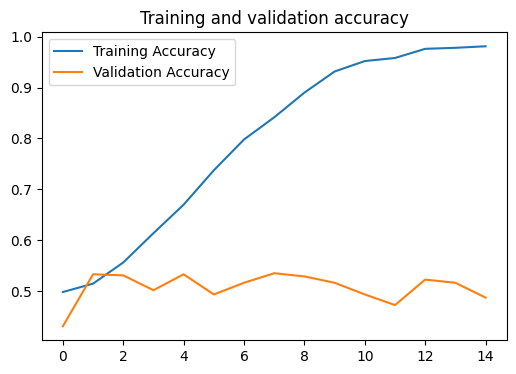

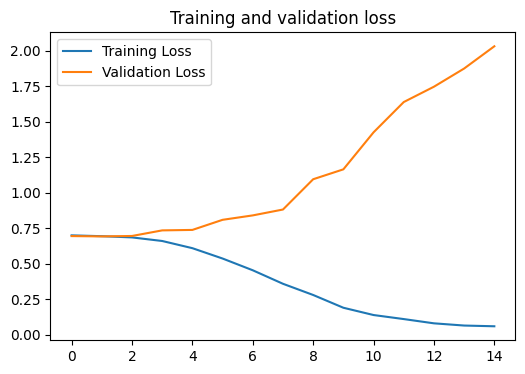

In [28]:
# Show chart of the accuracy and loss for both training and validation
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))
plt.style.use('default')

plt.figure(figsize=(6, 4))
plt.plot(epochs, acc, label='Training Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)

plt.figure(figsize=(6, 4))
plt.plot(epochs, loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.title('Training and validation loss')
plt.legend(loc=0)
plt.show()

In [29]:
# Create the model
size = int(path.split('/')[-1].split('_')[-1].split('x')[0])

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(size, size, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(48, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(96, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Show summary of the model
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 48, 48, 32)        896       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 24, 24, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 22, 22, 48)        13872     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 11, 11, 48)        0         
_________________________________________________________________
dropout (Dropout)            (None, 11, 11, 48)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 9, 9, 64)          27712     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 4, 4, 64)         

In [30]:
# Compile the model
from tensorflow.keras.optimizers import RMSprop

model.compile(loss='binary_crossentropy',
              optimizer=RMSprop(learning_rate=0.001),
              metrics=['accuracy'])

In [31]:
# Prepare image to fit the model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1/255)
validation_datagen = ImageDataGenerator(rescale=1/255)

train_generator = train_datagen.flow_from_directory(os.path.join(path, 'train'),
                                                    target_size=(size, size),
                                                    batch_size=20,
                                                    class_mode='binary')
validation_generator = validation_datagen.flow_from_directory(os.path.join(path, 'validation'),
                                                    target_size=(size, size),
                                                    batch_size=20,
                                                    class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 480 images belonging to 2 classes.


In [33]:
history = model.fit(train_generator,
                    steps_per_epoch=100,
                    epochs=100,
                    validation_data=validation_generator,
                    verbose=1)

Epoch 1/100
100/100 [==============================] - 3s 27ms/step - loss: 0.6387 - accuracy: 0.6445 - val_loss: 0.7058 - val_accuracy: 0.5167
Epoch 2/100
100/100 [==============================] - 3s 28ms/step - loss: 0.6150 - accuracy: 0.6655 - val_loss: 0.7268 - val_accuracy: 0.5083
Epoch 3/100
100/100 [==============================] - 3s 27ms/step - loss: 0.5952 - accuracy: 0.6890 - val_loss: 0.7602 - val_accuracy: 0.5208
Epoch 4/100
100/100 [==============================] - 3s 27ms/step - loss: 0.5721 - accuracy: 0.7050 - val_loss: 0.7600 - val_accuracy: 0.5063
Epoch 5/100
100/100 [==============================] - 3s 27ms/step - loss: 0.5241 - accuracy: 0.7445 - val_loss: 0.7521 - val_accuracy: 0.4938
Epoch 6/100
100/100 [==============================] - 3s 27ms/step - loss: 0.5074 - accuracy: 0.7515 - val_loss: 0.8248 - val_accuracy: 0.5250
Epoch 7/100
100/100 [==============================] - 3s 28ms/step - loss: 0.4919 - accuracy: 0.7680 - val_loss: 0.8313 - val_accuracy:

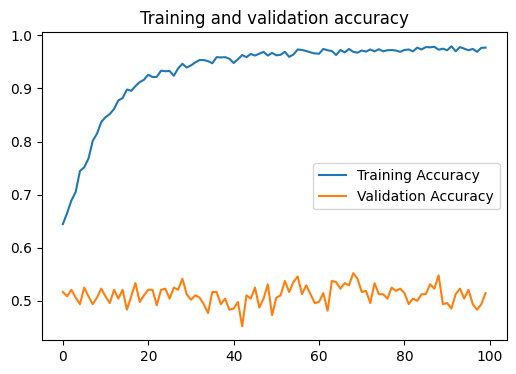

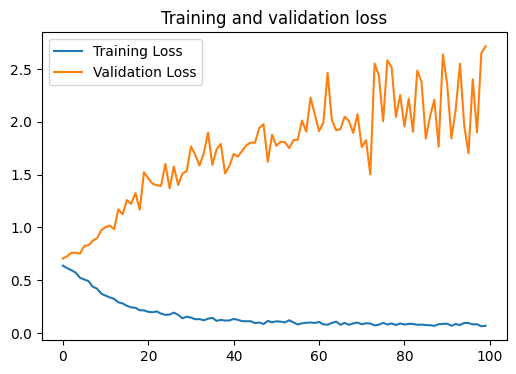

In [34]:
# Show chart of the accuracy and loss for both training and validation
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))
plt.style.use('default')

plt.figure(figsize=(6, 4))
plt.plot(epochs, acc, label='Training Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)

plt.figure(figsize=(6, 4))
plt.plot(epochs, loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.title('Training and validation loss')
plt.legend(loc=0)
plt.show()

<ipython-input-35-4cea2263c588>:39: RuntimeWarning: invalid value encountered in true_divide
  x /= x.std()


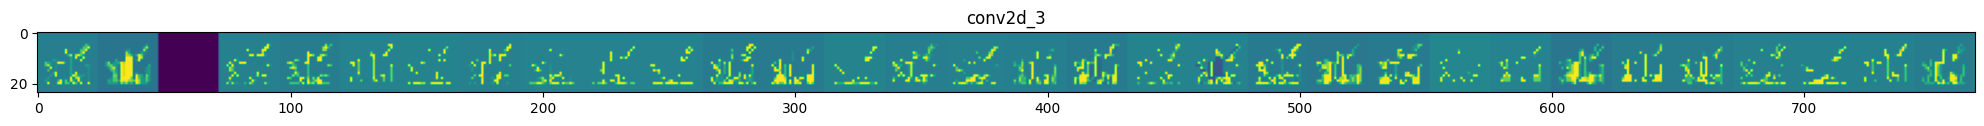

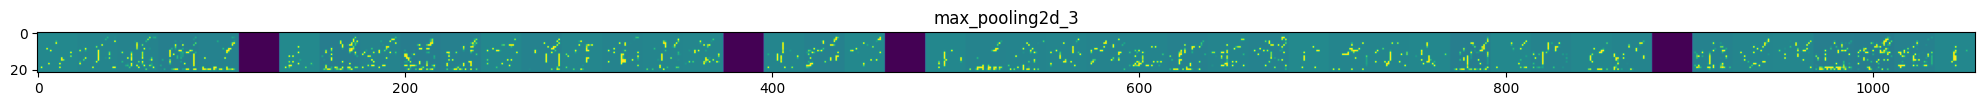

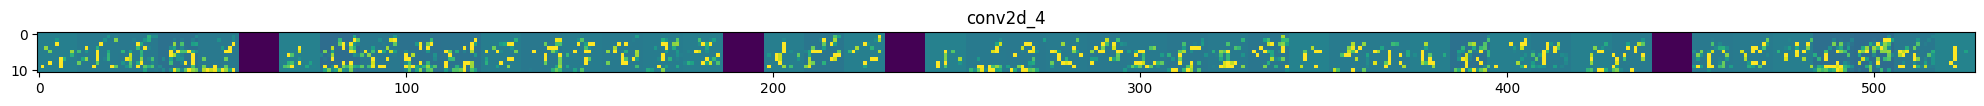

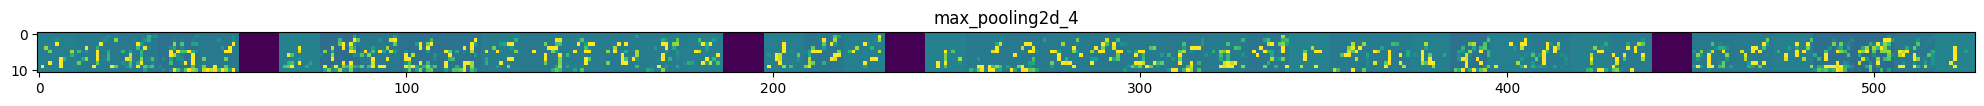

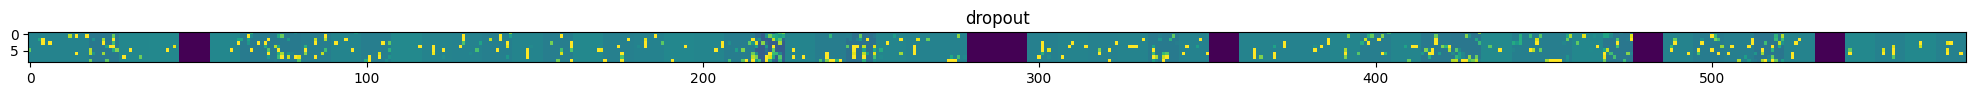

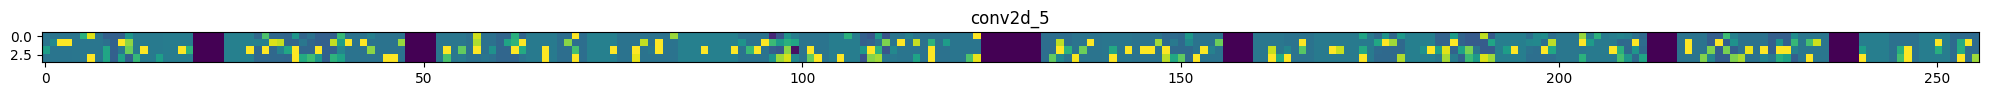

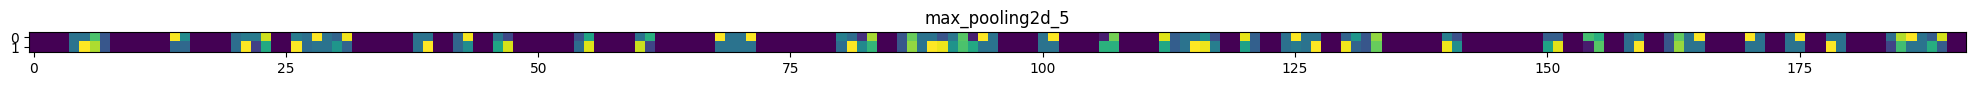

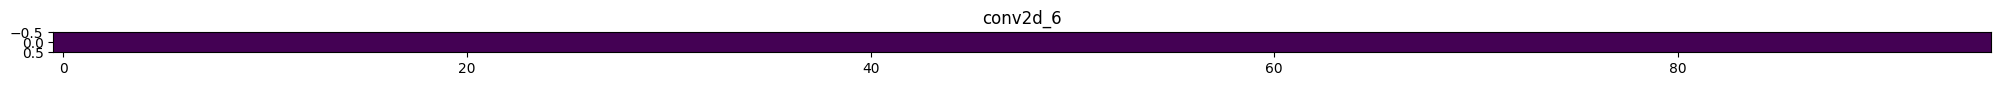

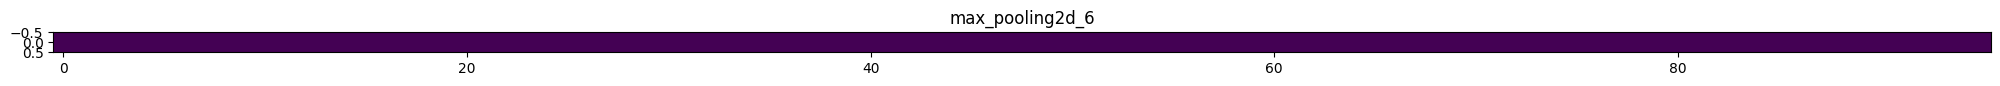

In [35]:
# Visualizing Intermediate Representations
# This is to get a feel for what features our convnet has learned.
import random
from tensorflow.keras.preprocessing.image import img_to_array, load_img

train_0_dir = os.path.join(path, 'train', '0')
train_1_dir = os.path.join(path, 'train', '1')
validation_0_dir = os.path.join(path, 'validation', '0')
validation_1_dir = os.path.join(path, 'validation', '1')

train_0_names = os.listdir(train_0_dir)
train_1_names = os.listdir(train_1_dir)
validation_0_names = os.listdir(validation_0_dir)
validation_1_names = os.listdir(validation_1_dir)
    
successive_outputs = [layer.output for layer in model.layers[1:]]
visualization_model = tf.keras.models.Model(inputs = model.input, outputs = successive_outputs)
img_0_files = [os.path.join(train_0_dir, f) for f in train_0_names]
img_1_files = [os.path.join(train_1_dir, f) for f in train_1_names]
img_path = random.choice(img_0_files + img_1_files)
img = load_img(img_path, target_size=(size, size))

x = img_to_array(img)
x = x.reshape((1,) + x.shape)
x /= 255

successive_feature_maps = visualization_model.predict(x)
layer_names = [layer.name for layer in model.layers]

#plt.style.use('dark_background')
for layer_name, feature_map in zip(layer_names, successive_feature_maps):
    if len(feature_map.shape) == 4:
        n_features = feature_map.shape[-1]
        size = feature_map.shape[1]
        display_grid = np.zeros((size, size * n_features))
        for i in range(n_features):
            x = feature_map[0, :, :, i]
            x -= x.mean()
            x /= x.std()
            x *= 64
            x += 128
            x = np.clip(x, 0, 255).astype('uint8')
            display_grid[:, i * size : (i + 1) * size] = x
        scale = 25. / n_features
        plt.figure(figsize=(scale * n_features, scale))
        plt.title(layer_name)
        plt.grid(False)
        plt.imshow(display_grid, aspect='auto', cmap='viridis')

In [47]:
# Test prediction results

from tensorflow.keras.preprocessing import image

test_path = 'stock_datasets/وغدير/images/20days_50x50pixel+volume/validation/0/1.png'
img = image.load_img(test_path, target_size=(50, 50))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
    
images = np.vstack([x])
classes = model.predict(images, batch_size=10)
print(classes[0])
if classes[0]>0.5:
    print("this belong to class 1")
else:
    print("this belong to class 0")

[0.]
this belong to class 0


In [50]:
createCandles('stock_datasets/وغدير/وغدير.csv', 20, 75, True)

image2dataset('stock_datasets/وغدير/images/20days_75x75pixel+volume', 'stock_datasets/وغدير/وغدير_label_20days.txt', 2000)

Converting numerical data to candlestick chart...
Symbol: وغدير
Converting numerical data to candlestick chart finished.
Address is:
/Users/omid/Downloads/files/master/4. Kusama2019/stock_datasets/وغدير/images/20days_75x75pixel+volume
Images converted to classified dataset.


In [51]:
# Use a pre-trained model

In [52]:
from tensorflow.keras.applications.inception_v3 import InceptionV3

local_weights_files = '/Users/omid/Downloads/files/Coursera - TensorFlow in Practice Specialization 2020-7/Datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

pre_trained_model = InceptionV3(input_shape = (75, 75, 3),
                                include_top = False,
                                weights = None)

pre_trained_model.load_weights(local_weights_files)

for layer in pre_trained_model.layers:
    layer.trainable = False

In [53]:
pre_trained_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 75, 75, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_7 (Conv2D)               (None, 37, 37, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 37, 37, 32)   96          conv2d_7[0][0]                   
__________________________________________________________________________________________________
activation (Activation)         (None, 37, 37, 32)   0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [54]:
last_layer = pre_trained_model.get_layer('mixed7')
print('last layer output shape:', last_layer.output_shape)
last_output = last_layer.output

last layer output shape: (None, 3, 3, 768)


In [55]:
from tensorflow.keras.optimizers import RMSprop

x = tf.keras.layers.Flatten()(last_output)
x = tf.keras.layers.Dense(256, activation='relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(1, activation='sigmoid')(x)

model = tf.keras.Model(pre_trained_model.input, x)

model.compile(loss='binary_crossentropy',
              optimizer=RMSprop(learning_rate=0.0001),
              metrics=['accuracy'])

In [56]:
base_dir = 'stock_datasets/وغدير/images/20days_75x75pixel+volume'

train_dir = 'stock_datasets/وغدير/images/20days_75x75pixel+volume/train'
validation_dir = 'stock_datasets/وغدير/images/20days_75x75pixel+volume/validation'

train_0_dir = os.path.join(train_dir, '0')
train_1_dir = os.path.join(train_dir, '1')
validation_0_dir = os.path.join(validation_dir, '0')
validation_1_dir = os.path.join(validation_dir, '1')

train_0_fnames = os.listdir(train_0_dir)
train_1_fnames = os.listdir(train_1_dir)

train_datagen = ImageDataGenerator(rescale=1/255)
tst_datagen = ImageDataGenerator(rescale=1/255)

train_generator = train_datagen.flow_from_directory(train_dir,
                                                    target_size=(75, 75),
                                                    batch_size=20,
                                                    class_mode='binary')

validation_generator = tst_datagen.flow_from_directory(validation_dir,
                                                    target_size=(75, 75),
                                                    batch_size=20,
                                                    class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 480 images belonging to 2 classes.


In [57]:
history = model.fit(
    train_generator,
    steps_per_epoch=100,
    epochs=100,
    validation_data=validation_generator,
    validation_steps=20,
    verbose=1)

Epoch 1/100
100/100 [==============================] - 10s 83ms/step - loss: 0.7454 - accuracy: 0.5005 - val_loss: 0.7015 - val_accuracy: 0.4950
Epoch 2/100
100/100 [==============================] - 6s 62ms/step - loss: 0.7074 - accuracy: 0.5375 - val_loss: 0.7055 - val_accuracy: 0.5400
Epoch 3/100
100/100 [==============================] - 6s 57ms/step - loss: 0.6792 - accuracy: 0.5630 - val_loss: 0.7343 - val_accuracy: 0.5300
Epoch 4/100
100/100 [==============================] - 6s 58ms/step - loss: 0.6792 - accuracy: 0.5800 - val_loss: 0.7399 - val_accuracy: 0.4700
Epoch 5/100
100/100 [==============================] - 6s 58ms/step - loss: 0.6614 - accuracy: 0.5945 - val_loss: 0.7229 - val_accuracy: 0.5300
Epoch 6/100
100/100 [==============================] - 6s 61ms/step - loss: 0.6509 - accuracy: 0.6090 - val_loss: 0.7383 - val_accuracy: 0.5050
Epoch 7/100
100/100 [==============================] - 6s 60ms/step - loss: 0.6448 - accuracy: 0.6050 - val_loss: 0.7371 - val_accuracy

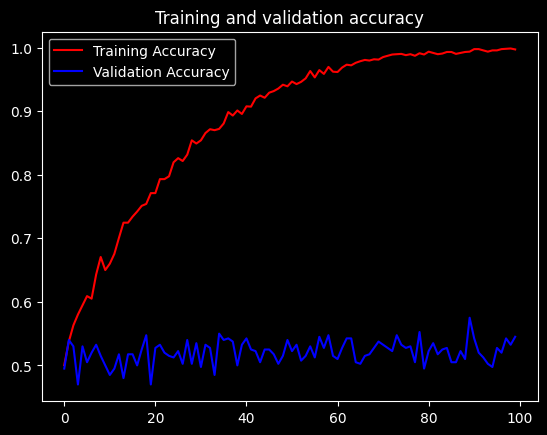

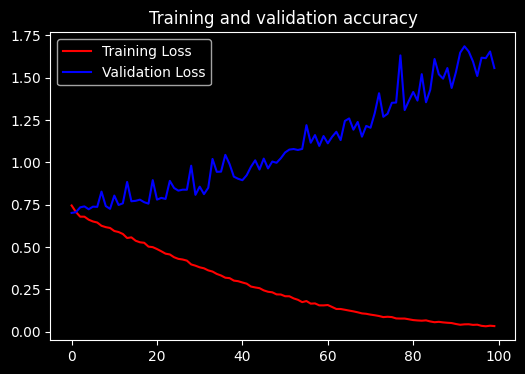

In [58]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training Accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation Accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure(figsize=(6, 4))

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.show()

In [59]:
path = 'stock_datasets/وغدير/images/20days_75x75pixel+volume'

In [61]:
from tensorflow.keras.applications.vgg16 import VGG16

local_weights_files = '/Users/omid/Downloads/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5'

pre_trained_model = VGG16(input_shape = (75, 75, 3),
                                include_top = False,
                                weights = None)

pre_trained_model.load_weights(local_weights_files)

for layer in pre_trained_model.layers:
    layer.trainable = False

In [62]:
pre_trained_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 75, 75, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 75, 75, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 75, 75, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 37, 37, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 37, 37, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 37, 37, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 18, 18, 128)       0     

In [63]:
last_layer = pre_trained_model.get_layer('block4_pool')
print('last layer output shape:', last_layer.output_shape)
last_output = last_layer.output

last layer output shape: (None, 4, 4, 512)


In [64]:
from tensorflow.keras.optimizers import RMSprop

x = tf.keras.layers.Flatten()(last_output)
x = tf.keras.layers.Dense(256, activation='relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(1, activation='sigmoid')(x)

model = tf.keras.Model(pre_trained_model.input, x)

model.compile(loss='binary_crossentropy',
              optimizer=RMSprop(learning_rate=0.0001),
              metrics=['accuracy'])

In [67]:
base_dir = 'stock_datasets/وغدير/images/20days_75x75pixel+volume'

train_dir = 'stock_datasets/وغدير/images/20days_75x75pixel+volume/train'
validation_dir = 'stock_datasets/وغدير/images/20days_75x75pixel+volume/validation'

train_0_dir = os.path.join(train_dir, '0')
train_1_dir = os.path.join(train_dir, '1')
validation_0_dir = os.path.join(validation_dir, '0')
validation_1_dir = os.path.join(validation_dir, '1')

train_0_fnames = os.listdir(train_0_dir)
train_1_fnames = os.listdir(train_1_dir)

train_datagen = ImageDataGenerator(rescale=1/255)
tst_datagen = ImageDataGenerator(rescale=1/255)

train_generator = train_datagen.flow_from_directory(train_dir,
                                                    target_size=(75, 75),
                                                    batch_size=20,
                                                    class_mode='binary')

validation_generator = tst_datagen.flow_from_directory(validation_dir,
                                                    target_size=(75, 75),
                                                    batch_size=20,
                                                    class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 480 images belonging to 2 classes.


In [69]:
history = model.fit(
    train_generator,
    steps_per_epoch=100,
    epochs=100,
    validation_data=validation_generator,
    validation_steps=20,
    verbose=1)

Epoch 1/100
100/100 [==============================] - 20s 204ms/step - loss: 0.8088 - accuracy: 0.5345 - val_loss: 0.7575 - val_accuracy: 0.5000
Epoch 2/100
100/100 [==============================] - 21s 214ms/step - loss: 0.6916 - accuracy: 0.5890 - val_loss: 0.7323 - val_accuracy: 0.5175
Epoch 3/100
100/100 [==============================] - 23s 228ms/step - loss: 0.6526 - accuracy: 0.6320 - val_loss: 0.7772 - val_accuracy: 0.5525
Epoch 4/100
100/100 [==============================] - 23s 230ms/step - loss: 0.6045 - accuracy: 0.6765 - val_loss: 0.7797 - val_accuracy: 0.5125
Epoch 5/100
100/100 [==============================] - 27s 267ms/step - loss: 0.5718 - accuracy: 0.7000 - val_loss: 0.7907 - val_accuracy: 0.5475
Epoch 6/100
100/100 [==============================] - 24s 241ms/step - loss: 0.5320 - accuracy: 0.7210 - val_loss: 0.9528 - val_accuracy: 0.4775
Epoch 7/100
100/100 [==============================] - 23s 230ms/step - loss: 0.4969 - accuracy: 0.7515 - val_loss: 0.8845 -

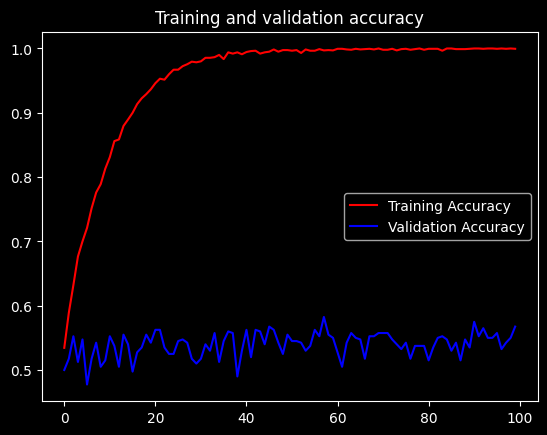

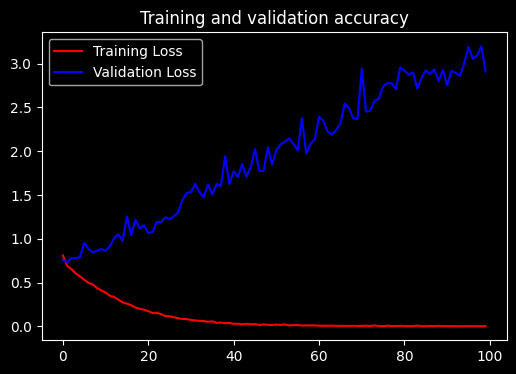

In [70]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training Accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation Accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure(figsize=(6, 4))

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.show()

<ipython-input-71-4cea2263c588>:39: RuntimeWarning: invalid value encountered in true_divide
  x /= x.std()


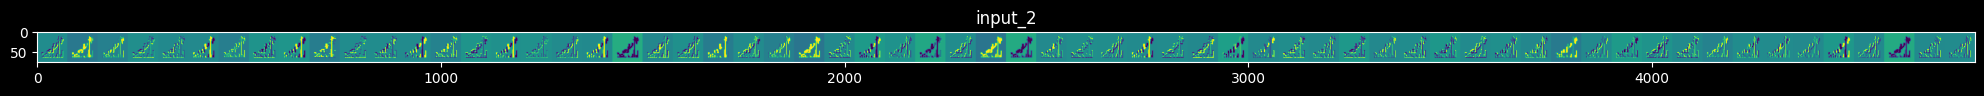

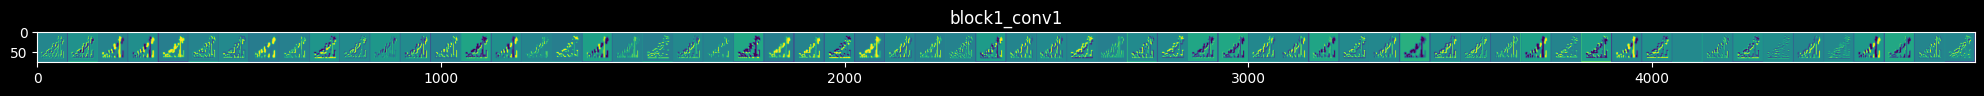

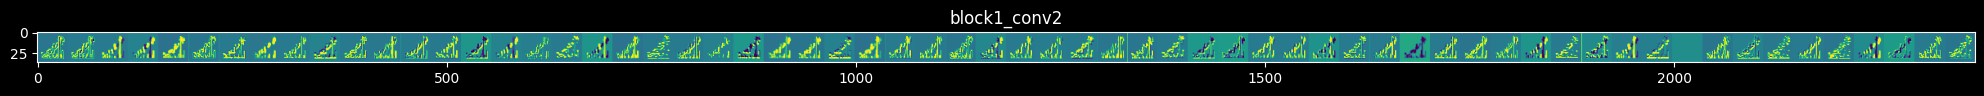

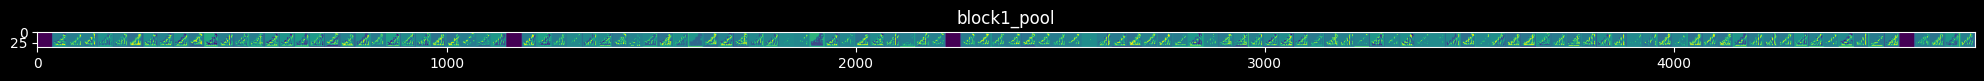

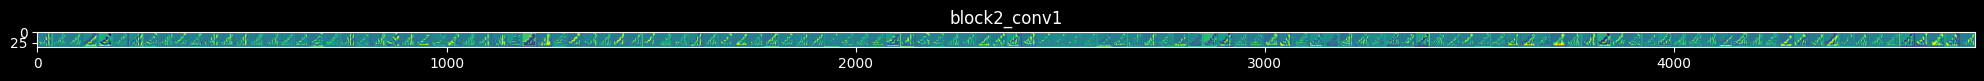

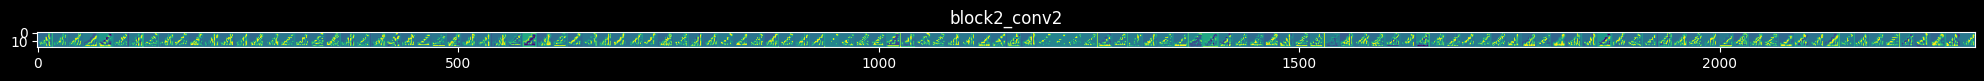

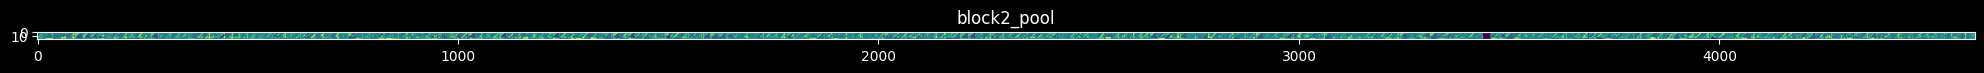

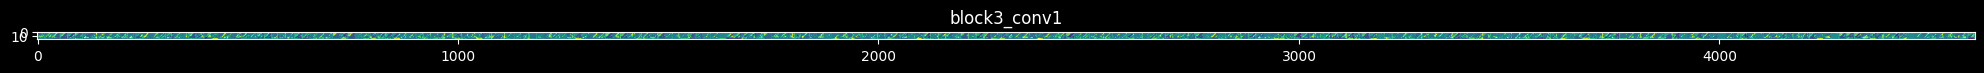

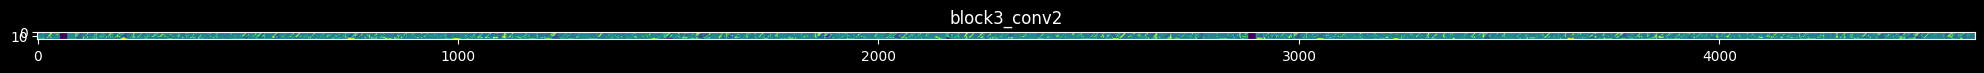

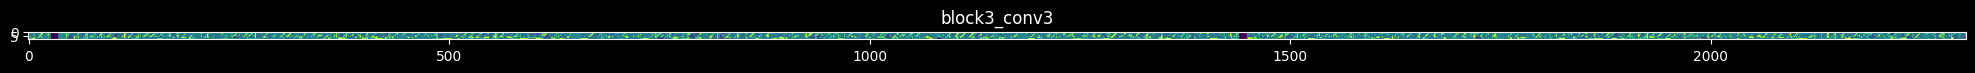

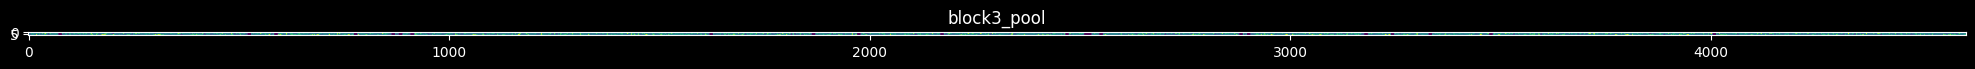

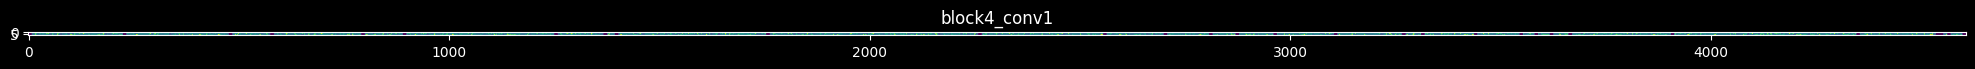

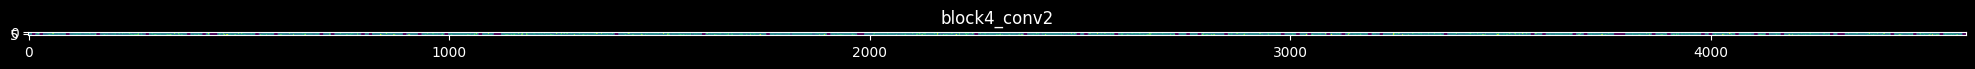

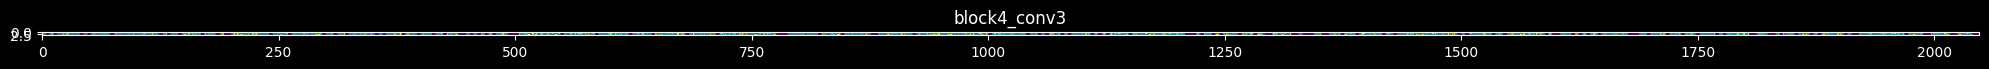

In [71]:
# Visualizing Intermediate Representations
# This is to get a feel for what features our convnet has learned.
import random
from tensorflow.keras.preprocessing.image import img_to_array, load_img

train_0_dir = os.path.join(path, 'train', '0')
train_1_dir = os.path.join(path, 'train', '1')
validation_0_dir = os.path.join(path, 'validation', '0')
validation_1_dir = os.path.join(path, 'validation', '1')

train_0_names = os.listdir(train_0_dir)
train_1_names = os.listdir(train_1_dir)
validation_0_names = os.listdir(validation_0_dir)
validation_1_names = os.listdir(validation_1_dir)
    
successive_outputs = [layer.output for layer in model.layers[1:]]
visualization_model = tf.keras.models.Model(inputs = model.input, outputs = successive_outputs)
img_0_files = [os.path.join(train_0_dir, f) for f in train_0_names]
img_1_files = [os.path.join(train_1_dir, f) for f in train_1_names]
img_path = random.choice(img_0_files + img_1_files)
img = load_img(img_path, target_size=(size, size))

x = img_to_array(img)
x = x.reshape((1,) + x.shape)
x /= 255

successive_feature_maps = visualization_model.predict(x)
layer_names = [layer.name for layer in model.layers]

#plt.style.use('dark_background')
for layer_name, feature_map in zip(layer_names, successive_feature_maps):
    if len(feature_map.shape) == 4:
        n_features = feature_map.shape[-1]
        size = feature_map.shape[1]
        display_grid = np.zeros((size, size * n_features))
        for i in range(n_features):
            x = feature_map[0, :, :, i]
            x -= x.mean()
            x /= x.std()
            x *= 64
            x += 128
            x = np.clip(x, 0, 255).astype('uint8')
            display_grid[:, i * size : (i + 1) * size] = x
        scale = 25. / n_features
        plt.figure(figsize=(scale * n_features, scale))
        plt.title(layer_name)
        plt.grid(False)
        plt.imshow(display_grid, aspect='auto', cmap='viridis')